<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/Abhi_CTCF_Replication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [2]:
!pip install pyfasta
!pip install deeptools
!pip install momma_dragonn

!apt-get install bedtools

#Download optimal IDR thresholded peaks
![[ -f idr_optimal_file.narrowPeak.gz ]] || wget https://www.encodeproject.org/files/ENCFF519CXF/@@download/ENCFF519CXF.bed.gz -O idr_optimal_file.narrowPeak.gz
  
#Get hg38 fasta by download 2bit and then converting to fa
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
  
#download hg38 chromsizes file
![[ -f hg38.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O hg38.chrom.sizes

  Running setup.py bdist_wheel for pyfasta ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ef/57/33/7b569168243dfbfe60bd3533e6897d170b391f2ce58df9d275
Successfully built pyfasta
    100% |████████████████████████████████| 3.3MB 10.3MB/s 
    100% |████████████████████████████████| 9.7MB 1.1MB/s 
    100% |████████████████████████████████| 71kB 22.4MB/s 
    100% |████████████████████████████████| 37.8MB 751kB/s 
    100% |████████████████████████████████| 3.1MB 9.1MB/s 
    100% |████████████████████████████████| 71kB 23.7MB/s 
    100% |████████████████████████████████| 8.1MB 5.0MB/s 
    100% |████████████████████████████████| 552kB 23.0MB/s 
  Running setup.py bdist_wheel for deeptools ... - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/26/7b/1a/e828c248cbb05db00a41118e24c0435bcdbf1b750f4dd2c0c8
  Running setup.py bdist_wheel for numpydoc ... - done
  Stored in directory: /root/.cache/pip/wheels/ea/55/7f/3e25d754760cc

In [0]:
#do an asinh transform of column 7 (SPP singal strength)
!zcat idr_optimal_file.narrowPeak.gz | perl -lane 'BEGIN{use Math::Trig} {print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))."\t".asinh($F[6])}' | bedtools slop -g hg38.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t$F[3]"}' | sortBed | gzip -c > positives_asinh_spp.gz
#15% of the regions go to validation and test set. Ensure no overlap between test, valid and train sets using bedtools intersect -v
!zcat positives_asinh_spp.gz | perl -lne 'if ($.%15==0) {print $_}' | gzip -c > test_positives_asinh_spp.gz
!bedtools intersect -sorted -v -a <(zcat positives_asinh_spp.gz | perl -lne 'if ($.%15==10) {print $_}') -b test_positives_asinh_spp.gz -wa | gzip -c > valid_positives_asinh_spp.gz
!bedtools intersect -sorted -v -a positives_asinh_spp.gz -b <(zcat valid_positives_asinh_spp.gz test_positives_asinh_spp.gz | sortBed) -wa | gzip -c > train_positives_asinh_spp.gz


In [0]:
import keras
from keras.models import Model
from momma_dragonn.data_loaders import pyfasta_data_loader
import six
from scipy.stats import spearmanr
import numpy as np


def get_single_stream_data_generator(bed_source, batch_size):

  return pyfasta_data_loader.SingleStreamSeqOnly(
               batch_size=batch_size,
               bed_source=bed_source,
               fasta_data_source="hg38.genome.fa",
               rc_augment=True,
               num_to_load_for_eval=100, #not used
               labels_dtype="float",
               wrap_in_keys=["sequence", "output"],
               randomize_after_pass=True)


def get_core_model(num_conv_filters,
                   conv_filter_length,
                   pool_length_and_stride,
                   num_dense_units):
  input = keras.layers.Input(shape=(1000,4), name="sequence")
  conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              padding="same")(input)
  conv1relu = keras.layers.core.Activation(activation="relu")(conv1)
  conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
  conv2relu = keras.layers.core.Activation(activation="relu")(conv2)
  conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
  conv3relu = keras.layers.core.Activation(activation="relu")(conv3)
  avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
  flatten = keras.layers.core.Flatten()(avgpool)
  dense1 = keras.layers.core.Dense(units=num_dense_units[0])(flatten)
  dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
  
  return (input, dense1relu)


def train_regression_model(num_outputs,
                           train_bed_source,
                           valid_bed_source,
                           steps_per_epoch=200,
                           batch_size=128,
                           adam_lr=0.001,
                           num_validation_samples=3500,
                           num_conv_filters=15,
                           conv_filter_length=15,
                           pool_length_and_stride=5,
                           num_dense_units=[100],
                           preinit_model=None,
                           epochs_to_train_for=60):
  
  validation_steps = int(num_validation_samples/batch_size)
  
  
  class SpearmanCorrCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps, valid_data_generator):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print(spearmanr(a=valid_data_labels[:,0],
                      b=valid_data_preds[:,0]))
      
  
  if (preinit_model is None):
    
    (input,dense1relu) = get_core_model(
        num_conv_filters=num_conv_filters,
        conv_filter_length=conv_filter_length,
        pool_length_and_stride=pool_length_and_stride,
        num_dense_units=num_dense_units)
    output = keras.layers.core.Dense(units=num_outputs,
                                     name="output")(dense1relu)
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": "mse"})
  else:
    model = preinit_model
  
  model.summary()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_single_stream_data_generator(
      bed_source=train_bed_source,
      batch_size=batch_size).get_batch_generator(),
    validation_data= get_single_stream_data_generator(
      bed_source=valid_bed_source,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               SpearmanCorrCallback(
                   valid_data_generator=get_single_stream_data_generator(
                      bed_source=valid_bed_source,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

In [7]:
from matplotlib import pyplot as plt

positives_asinh_spp_model, positives_asinh_spp_fit_history = train_regression_model(
                             num_outputs=1,
                             train_bed_source="train_positives_asinh_spp.gz",
                             valid_bed_source="valid_positives_asinh_spp.gz")


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 15)          915       
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_2 (Activation)    (None, 1000, 15)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 15)          3390      
_________________________________________________________________
activation_3 (Activation)    (None, 1000, 15)          0         
__________

In [13]:
from collections import OrderedDict
import numpy as np

def iterate_over_generator_in_batches(batch_size, generator):
  X_batch = []
  y_batch = []
  for (X_ex, y_ex, coor, fastastr) in generator:
    X_batch.append(X_ex)
    y_batch.append(y_ex)
    if (len(X_batch)==batch_size):
      yield np.array(X_batch), np.array(y_batch)
      X_batch = []
      y_batch = []
  if (len(X_batch) > 0):
    yield np.array(X_batch), np.array(y_batch)
    
def get_predictions_and_true_labels(bed_source, name_to_model): 
  generator = pyfasta_data_loader.SingleStreamSeqOnly(
     batch_size=None,
     bed_source=bed_source,
     fasta_data_source="hg38.genome.fa",
     rc_augment=True,
     num_to_load_for_eval=None, #not used
     labels_dtype="float",
     wrap_in_keys=["sequence", "output"],
     randomize_after_pass=False).get_generator(loop_infinitely=False)  
  name_to_predictions = OrderedDict()
  true_y = []
  for X_batch, y_batch in iterate_over_generator_in_batches(
                            batch_size=200, generator=generator):
    true_y.extend(y_batch)
    for name in name_to_model:
      if name not in name_to_predictions:
        name_to_predictions[name] = []
      name_to_predictions[name].extend(name_to_model[name].predict(
                                       {'sequence': X_batch}))
  for name in name_to_predictions:
    name_to_predictions[name] = np.array(name_to_predictions[name])
  return np.array(true_y), name_to_predictions
    
positives_asinh_spp_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model}


#verify no train-test contamination!
!bedtools intersect -sorted -a test_positives_asinh_spp.gz -b train_positives_asinh_spp.gz | wc -l
!bedtools intersect -sorted -a valid_positives_asinh_spp.gz -b train_positives_asinh_spp.gz | wc -l
!bedtools intersect -sorted -a test_positives_asinh_spp.gz -b valid_positives_asinh_spp.gz | wc -l

test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="test_positives_asinh_spp.gz",
    name_to_model=positives_asinh_spp_name_to_model)
train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="train_positives_asinh_spp.gz",
    name_to_model=positives_asinh_spp_name_to_model)
valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="valid_positives_asinh_spp.gz",
    name_to_model=positives_asinh_spp_name_to_model)

0
0
0
Reading bed file test_positives_asinh_spp.gz into memory
Finished reading bed file into memory; got 3317rows


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: generator 'get_pyfasta_generator' raised StopIteration
  import sys


Reading bed file train_positives_asinh_spp.gz into memory
Finished reading bed file into memory; got 41162rows
Reading bed file valid_positives_asinh_spp.gz into memory
Finished reading bed file into memory; got 3318rows


Split name test


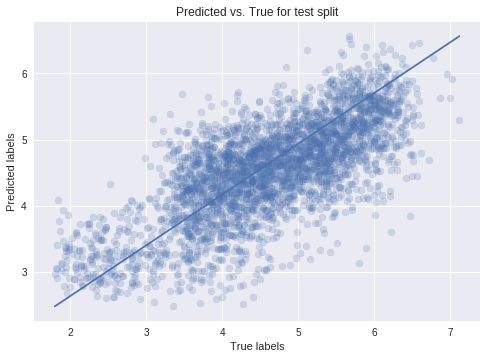

SpearmanrResult(correlation=0.6939765997251977, pvalue=0.0)
Split name valid


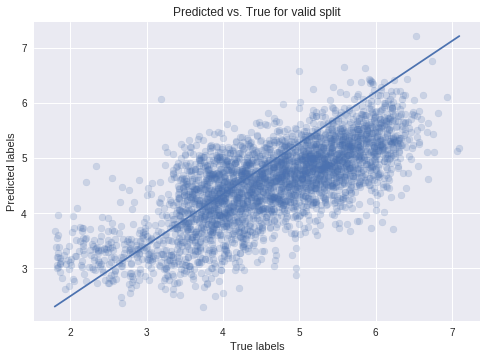

SpearmanrResult(correlation=0.7051641766699266, pvalue=0.0)
Split name train


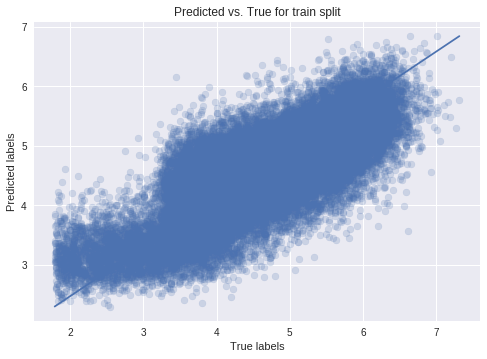

SpearmanrResult(correlation=0.7530269935049113, pvalue=0.0)


In [17]:
from scipy.stats import spearmanr
for split_name, split_labels, split_modelname_to_predictions in [
    ('test', test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions),
    ('valid', valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions),
    ('train', train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions)]:
  print("Split name",split_name)
  for modelname in split_modelname_to_predictions:
    plt.scatter(split_labels[:,0],
                split_modelname_to_predictions[modelname][:,0], alpha=0.2)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")
    plt.title("Predicted vs. True for "+split_name+" split")
    plt.plot([np.min(split_labels), np.max(split_labels)],
             [np.min(split_modelname_to_predictions[modelname][:,0]),
              np.max(split_modelname_to_predictions[modelname][:,0])])
    plt.show()
    print(spearmanr(a=split_labels[:,0],
                    b=split_modelname_to_predictions[modelname][:,0]))

In [89]:
import os
import sys
import gzip
from collections import OrderedDict

def tile_across_genome(chrom_sizes_file,
                       chroms_to_exclude,
                       out_file, bin_sizes,
                       bin_stride):

    chromosome_sizes = OrderedDict()
    for line in open(chrom_sizes_file):
        chrom, size = line.rstrip().split("\t")
        if (("_" not in chrom) and
            (chrom not in chroms_to_exclude)):
            size = int(size)
            chromosome_sizes[chrom] = size 
        else:
            pass
            #print("Dropping chrom",chrom)

    outfile = open(out_file, "w")
    
    for a_chrom in chromosome_sizes:
        the_end = chromosome_sizes[a_chrom] 
        bin_start = 0
        while ((bin_start + bin_sizes) < the_end):
            outfile.write(a_chrom+"\t"+str(bin_start)
                          +"\t"+str(bin_start+bin_sizes)+"\n")
            bin_start += bin_stride

    outfile.close()

if (os.path.isfile("1kb_tiles.bed")==False):
  print("Tiling across the genome in 1kb windows")
  tile_across_genome(out_file = "1kb_tiles.bed",
                     chrom_sizes_file="hg38.chrom.sizes",
                     bin_sizes=1000,
                     bin_stride=1000,
                     chroms_to_exclude=["chrM"])    
    
# Positive set: 1kb around IDR-optimal peaks
![[ -f positive_regions.gz ]] || zcat idr_optimal_file.narrowPeak.gz | perl -lane 'print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))' | bedtools slop -g hg38.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1"}' | sortBed | gzip -c > positive_regions.gz
# Negative set: 1kb regions tiling across the genome that do not overlap any of the peaks in the idr file
![[ -f negative_regions.gz ]] || bedtools intersect -sorted -v -a 1kb_tiles.bed -b  positive_regions.gz -wa | perl -lane 'print $F[0]."\t".$F[1]."\t".$F[2]."\t0"' | gzip -c > negative_regions.gz
#Put positive and negative set together into "binary_labels.gz"
![[ -f binary_labels.gz ]] || zcat positive_regions.gz negative_regions.gz | sortBed | gzip -c > binary_labels.gz

print("Extracting foldchange signal")
####
##Because this can take a while, a quicker alternative is to copy over the saved result
##The original code is here:
####
##Download the bigwig signal
#![[ -f signal.bw ]] || wget https://www.encodeproject.org/files/ENCFF405AYC/@@download/ENCFF405AYC.bigWig -O signal.bw
##prepare bed file for multiBigWigSummary
#!zcat binary_labels.gz | perl -lane 'print("$F[0]\t".($F[1]+400)."\t".($F[2]-400)."\t".$F[0].":".$F[1]."-".$F[2])' > central_200bp_for_bwaob.bed 
## run multiBigWigSummary on the above bed file 
#![[ -f central_200bp_avgsignal.tab.gz ]] || multiBigwigSummary BED-file  --numberOfProcessors max -b signal.bw -o central_200bp_avgsignal.npz --outRawCounts central_200bp_avgsignal.tab --BED central_200bp_for_bwaob.bed
#![[ -f central_200bp_avgsignal.tab.gz ]] || gzip central_200bp_avgsignal.tab
####
##The code below downloads central_200bp_avgsignal_ENCFF405AYC_ENCFF519CXF.tab and renames it to central_200bp_avgsignal.tab
####
![[ -f central_200bp_avgsignal.tab.gz ]] || curl -L "https://docs.google.com/uc?export=download&id=1-AVFqQ_dF8l9nRaC-M28REP6x0nUwEPg" > central_200bp_avgsignal_ENCFF405AYC_ENCFF519CXF.tab.gz
![[ -f central_200bp_avgsignal.tab.gz ]] || mv central_200bp_avgsignal_ENCFF405AYC_ENCFF519CXF.tab.gz central_200bp_avgsignal.tab.gz

#add the signal to the binary labels
![[ -f binary_labels_and_signal.gz ]] || paste <(zcat binary_labels.gz) <(zcat central_200bp_avgsignal.tab.gz | sortBed | cut -f4) | gzip -c > binary_labels_and_signal.gz

Extracting foldchange signal
